In [1]:
import os
import shutil
from functools import partial
from multiprocessing import Pool

import matplotlib.pyplot as plt
import mutagen
from mutagen.flac import FLAC, Picture
from mutagen.id3 import APIC, ID3
from mutagen.mp4 import MP4
from pydub import AudioSegment
from pydub.playback import play
from pydub.utils import mediainfo

In [7]:
input_folder = "../../files/Rocks_normalized/"
output_folder = "../../files/tmp_normalized/"
num_workers = 15

In [3]:
def divide_list(lst, n):
    """
    Divides a list equally into n sublists.

    Args:
    lst: The list to be divided.
    n: The number of sublists to create.

    Returns:
    A list of sublists.
    """
    sublist_size = len(lst) // n
    extra = len(lst) % n
    sublists = []
    start = 0
    for i in range(n):
        end = start + sublist_size
        if i < extra:
            end += 1
        sublists.append(lst[start:end])
        start = end
    return sublists


def normalize_audio(file: str, target_dBFS):
    try:
        input_file = os.path.join(input_folder, file)
        output_file = os.path.join(output_folder, file)

        # Load the audio file
        audio = AudioSegment.from_file(input_file)
        if target_dBFS - 1 <= audio.dBFS and audio.dBFS <= target_dBFS + 1:
            shutil.copy2(input_file, output_file)
            print(f"No need to convert, copied: {input_file}")
            return

        # Calculate the difference in loudness
        change_in_dBFS = target_dBFS - audio.dBFS

        # Apply gain to normalize
        normalized_audio = audio.apply_gain(change_in_dBFS)

        # Export normalized audio with the original bitrate
        ext = file.rsplit(".", 1)[-1]
        if ext == "m4a":
            _format = "ipod"
            
            info = mediainfo(input_file)
            original_bitrate = info.get("bit_rate")
            original_bitrate = round(int(original_bitrate)/1000)
            original_bitrate = f"{original_bitrate}k"
        elif ext == "flac":
            _format = "flac"
            original_bitrate = None
        elif ext == "mp3":
            _format = "mp3"
            original_bitrate = f"{audio.frame_rate}k"
        
        normalized_audio.export(
            output_file,
            format=_format,
            bitrate=original_bitrate,
        )

        if ext == "flac":
            original_tags = FLAC(input_file)
            new_tags = FLAC(output_file)
            
            for tag, value in original_tags.tags.items():
                new_tags[tag] = value

            for picture in original_tags.pictures:
                img = Picture()
                img.type = picture.type
                img.mime = picture.mime
                img.desc = picture.desc
                img.data = picture.data
                new_tags.add_picture(img)

            new_tags.save(output_file)
        elif ext == "mp3":
            # Copy metadatas
            original_tags = ID3(input_file)
            new_tags = ID3(output_file)

            # Copy tags & cover
            for tag in original_tags.keys():
                new_tags[tag] = original_tags[tag]
                if isinstance(original_tags[tag], APIC):
                    new_tags.add(original_tags[tag])
            new_tags.save(output_file)
        elif ext == "m4a":
            audio = MP4(input_file)
            audio_dest = MP4(output_file)

            # Copy tags
            for key, value in audio.items():
                audio_dest[key] = value


            # Save the tags to the destination file
            audio_dest.save()

        print(f"Normalized: {input_file} -> {output_file}")
    except Exception as e:
        print(f"Error processing {input_file}: {e}")


def normalize_audios(files: list[str], target_dBFS):
    for f in files:
        normalize_audio(f, target_dBFS)


# Main function
def normalize_folder(input_folder, output_folder, target_dBFS):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    sublists = divide_list(os.listdir(input_folder), num_workers)
    f = partial(normalize_audios, target_dBFS=target_dBFS)
    with Pool(processes=num_workers) as pool:
        results = pool.map(f, sublists)


def get_loudness(input_folder):
    loudness_list = []
    for root, _, files in os.walk(input_folder):
        for file in files:
            input_file = os.path.join(root, file)
            try:
                audio = AudioSegment.from_file(input_file)
                loudness_list.append((input_file, audio.dBFS))
            except Exception as e:
                print(f"Error reading {input_file}: {e}")
    return loudness_list

In [4]:
normalize_folder(input_folder, output_folder, target_dBFS=-10.0) 

No need to convert, copied: ../../files/tmp/Given Up.flac
No need to convert, copied: ../../files/tmp/Highway to Hell (feat. Bruce Springsteen & Eddie Vedder).flac
No need to convert, copied: ../../files/tmp/Beggin'.mp3
No need to convert, copied: ../../files/tmp/Boulevard of Broken Dreams.flac
No need to convert, copied: ../../files/tmp/Wake Me Up When September Ends.flac
No need to convert, copied: ../../files/tmp/Waiting for the End.flac
Normalized: ../../files/tmp/We Are The Champions.flac -> ../../files/tmp_normalized/We Are The Champions.flac
Normalized: ../../files/tmp/9 Crimes.flac -> ../../files/tmp_normalized/9 Crimes.flac
Normalized: ../../files/tmp/Time Is Running Out.flac -> ../../files/tmp_normalized/Time Is Running Out.flac
Normalized: ../../files/tmp/Staying Alive (1977).flac -> ../../files/tmp_normalized/Staying Alive (1977).flac
Normalized: ../../files/tmp/Thank You (Falettinme Be Mice Elf Agin).flac -> ../../files/tmp_normalized/Thank You (Falettinme Be Mice Elf Agin

(268,
 (array([ 16.,  10.,  16.,  22., 155.,  11.,  11.,   8.,   9.,  10.]),
  array([-10.96834106, -10.77401515, -10.57968924, -10.38536333,
         -10.19103743,  -9.99671152,  -9.80238561,  -9.6080597 ,
          -9.4137338 ,  -9.21940789,  -9.02508198]),
  <BarContainer object of 10 artists>))

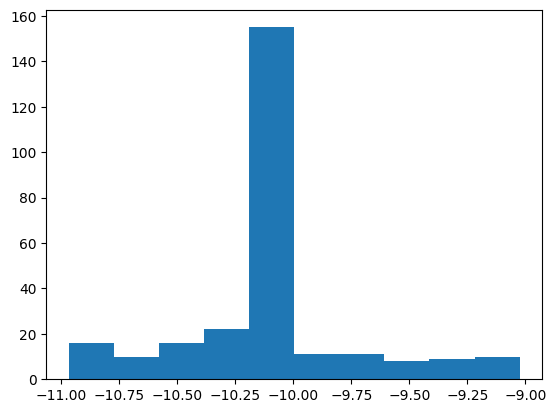

In [8]:
loudnesses = get_loudness(input_folder)
volumes = [x[1] for x in loudnesses]
len(volumes), plt.hist(volumes)

(array([2., 0., 2., 1., 5., 0., 0., 2., 0., 1.]),
 array([-10.96646708, -10.77232857, -10.57819006, -10.38405155,
        -10.18991304,  -9.99577453,  -9.80163602,  -9.60749751,
         -9.413359  ,  -9.21922049,  -9.02508198]),
 <BarContainer object of 10 artists>)

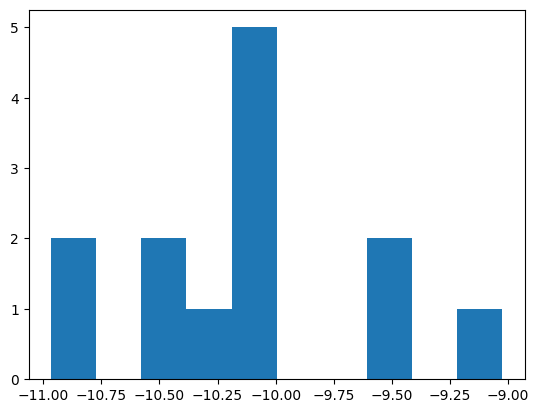

In [6]:
loudnesses = get_loudness(output_folder)
volumes = [x[1] for x in loudnesses]
plt.hist(volumes)